In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 50. データの入手・整形
News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．  
2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
3. 抽出された事例をランダムに並び替える．  
4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．  
6. 学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [2]:
# データの読み込み
# .csv 拡張子だがこのファイルは"タブ区切り". 正確には .tsvファイル
#  .tsv, .ssv などを総称して csvファイルと呼ぶらしい． README.mdを読むことが重要 !
with open("data/NewsAggregatorDataset/newsCorpora.csv", "r") as f:
    df = pd.read_csv(f, sep="\t", header=None, names=[" ID", "TITLE", "URL", "PUBLISHER", "CATEGORY", "STORY" ,"HOSTNAME", "TIMESTAMP"])

In [3]:
# データの確認
df.head(3)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550


In [4]:
# 特定の記事を抽出
extract_df = df[df["PUBLISHER"].isin(["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"])]

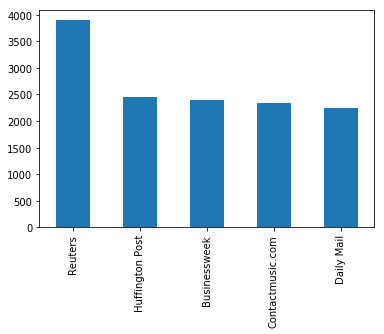

In [5]:
# 確認
publisher_var = extract_df["PUBLISHER"].value_counts()
publisher_var.plot.bar()

In [6]:
# 再現性を高めるために random_stateは設定しておく方が良い
# stratifyはCATEGORYの比率を揃えるために指定しておく
extract_df = extract_df[["CATEGORY", "TITLE"]]
train_df, val_test_df = train_test_split(extract_df, test_size=0.2, shuffle=True, random_state=2021, stratify=extract_df["CATEGORY"])
val_df, test_df = train_test_split(val_test_df, test_size=0.5, shuffle=True, random_state=2021, stratify=val_test_df["CATEGORY"])

In [7]:
print("訓練データ ： {}".format(train_df.shape))
print("検証データ ： {}".format(val_df.shape))
print("テストデータ ： {}".format(test_df.shape))

訓練データ ： (10672, 2)
検証データ ： (1334, 2)
テストデータ ： (1334, 2)


In [8]:
train_df.to_csv("data/NewsAggregatorDataset/train.txt", sep="\t", index=None)
val_df.to_csv("data/NewsAggregatorDataset/valid.txt", sep="\t", index=None)
test_df.to_csv("data/NewsAggregatorDataset/test.txt", sep="\t", index=None)

### CATEGORY 
- b = business
- t = science and technology
- e = entertainment
- m = health

b    4502
e    4223
t    1219
m     728
Name: CATEGORY, dtype: int64


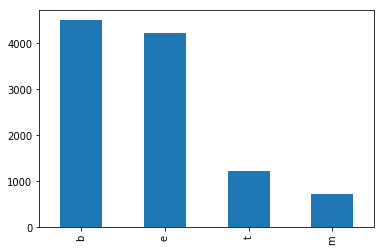

In [9]:
train_category_var = train_df["CATEGORY"].value_counts()
print(train_category_var)
train_category_var.plot.bar()

b    562
e    528
t    153
m     91
Name: CATEGORY, dtype: int64


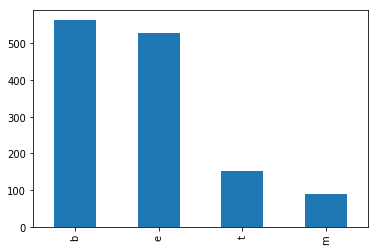

In [10]:
val_category_var = val_df["CATEGORY"].value_counts()
print(val_category_var)
val_category_var.plot.bar()

b    563
e    528
t    152
m     91
Name: CATEGORY, dtype: int64


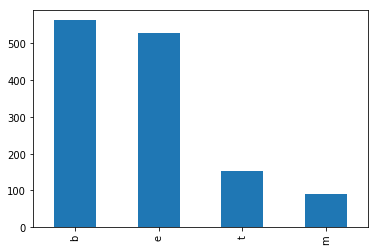

In [11]:
test_category_var = test_df["CATEGORY"].value_counts()
print(test_category_var)
test_category_var.plot.bar()

## 51. 特徴量抽出
1. 学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ．  
2. なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

### 特徴量の作り方
- Bag Of Words
    - ノーマル
    - TF-IDF
- 単語の分散表現 
    - Word2Vec(2013年/Google) 
    - Glove(2014年/Stanford大学)
    - FastText(2016年/Facebook) ... どちらかとういうと未知語に強い
- 文の分散表現
    - 単語の分散表現の平均
    - TF-IDFを用いて分散表現の重み付き平均
    - BERT(2018年/Google)
    - ELMo(2018年/Allen AI・Washington大学)

In [12]:
# TF-IDFを用いたBag Of Words
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

stopwords = stopwords.words('english')
# min_df = N : ある単語の出現回数がN回より少なかったら削除する(min_df = 0 と min_df = 1 は同じ意味)
# min_df = 1(default)  : 12295 単語(全部の単語) 
# min_df = 2 :  7314単語
# min_df = 3 :  5304単語
# min_df = 4 :  4200単語 
# ...デフォルトが一番精度良い(単語を削除しない) 
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords, ngram_range=(2,4), min_df=1) 

train_scipy =tfidf_vectorizer.fit_transform(train_df["TITLE"])
val_scipy = tfidf_vectorizer.transform(val_df["TITLE"]) 
test_scipy = tfidf_vectorizer.transform(test_df["TITLE"]) 

# scipy -> array に変換
train_array = train_scipy.toarray()
val_array = val_scipy.toarray()
test_array = test_scipy.toarray()

# array -> dataframe に変換
train_feature_df = pd.DataFrame(data=train_array, columns=tfidf_vectorizer.get_feature_names())
val_feature_df = pd.DataFrame(data=val_array, columns=tfidf_vectorizer.get_feature_names())
test_feature_df = pd.DataFrame(data=test_array, columns=tfidf_vectorizer.get_feature_names())
train_feature_df.head()

,00 bst,05 12,05 12 50,05 12 50 cent,05 12 entertainment,05 12 entertainment solange,05 12 fox,05 12 fox unveils,08 holcim,08 holcim lafarge,...,œf ck youâ cop,œlousyâ lost,œlousyâ lost riverâ,œlousyâ lost riverâ bum,œpiece meatâ,œpiece meatâ fbi,œpiece meatâ fbi denies,œwaist upâ,œwaist upâ star,œwaist upâ star wars
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# ノーマルのBag Of Words
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

stopwords = stopwords.words('english')
# min_df = N : ある単語の出現回数がN回より少なかったら削除する(min_df = 0 と min_df = 1 は同じ意味)
# min_df = 1(default)  : 12295 単語(全部の単語) 
# min_df = 2 :  7314単語
# min_df = 3 :  5304単語
# min_df = 4 :  4200単語 
# ngram_range(1, 3) ... 1gram から 3gramまでの単語を全て使う(3,4gramまで使うと精度が上がる)
count_vectorizer = CountVectorizer(stop_words=stopwords,ngram_range=(1, 3), min_df=2) 

# sklearn のデフォルトのstopwordsは酷いため使わない方が良い
# sklearn はデフォルトで記号以外の2文字以上のもののみ使用
# fit() ... データの語彙を獲得
# tranfsorm() ... fit()で得た語彙を用いて計算(fitで得ていない単語については計算できない)
# fit_transform() ... fit() + transform()

train_scipy = count_vectorizer.fit_transform(train_df["TITLE"]) #単語を獲得
val_scipy = count_vectorizer.transform(val_df["TITLE"]) # 訓練データで得た単語のみを用いて計算
test_scipy = count_vectorizer.transform(test_df["TITLE"]) # 訓練データで得た単語のみを用いて計算

# scipy -> array に変換
train_array = train_scipy.toarray()
val_array = val_scipy.toarray()
test_array = test_scipy.toarray()

# array -> dataframe に変換
train_feature_df = pd.DataFrame(data=train_array, columns=count_vectorizer.get_feature_names())
val_feature_df = pd.DataFrame(data=val_array, columns=count_vectorizer.get_feature_names())
test_feature_df = pd.DataFrame(data=test_array, columns=count_vectorizer.get_feature_names())

train_feature_df.to_csv('train.feature.txt', sep='\t', index=False)
val_feature_df.to_csv('valid.feature.txt', sep='\t', index=False)
test_feature_df.to_csv('test.feature.txt', sep='\t', index=False)

train_feature_df.head()

,00,00 bst,10,10 billion,10 billion valuation,10 billion value,10 bln,10 bln us,10 pct,10 percent,...,zone inflation,zone inflation drops,zone manufacturing,zone shares,zone stumbles,zone yields,zuckerberg,zynga,zynga lures,zynga lures best
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 52. 学習
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [14]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=2021, max_iter=10000)
model.fit(train_feature_df, train_df['CATEGORY'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2021, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## 53. 予測
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [15]:
import numpy as np

def pred_score(model, x):
    pred = model.predict(x)
    score = np.max(model.predict_proba(x), axis=1)
    return pred, score

train_pred, train_score = pred_score(model, train_feature_df)
val_pred, val_score = pred_score(model, val_feature_df)
test_pred, test_score = pred_score(model, test_feature_df)
print(train_pred, train_score)
print(val_pred, val_score)
print(test_pred, test_score)

['t' 'e' 'b' ... 'b' 'b' 'e'] [0.98359285 0.9478732  0.99084245 ... 0.74195889 0.96641315 0.93824837]
['t' 'b' 'e' ... 'e' 'b' 'b'] [0.59690947 0.91517901 0.9777096  ... 0.56707935 0.99971263 0.96286805]
['b' 'b' 'b' ... 'b' 'e' 'e'] [0.90885597 0.99410099 0.40196388 ... 0.98187975 0.94721426 0.89944952]


## 54. 正解率の計測
52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [16]:
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(train_df['CATEGORY'], train_pred)
test_accuracy = accuracy_score(test_df['CATEGORY'], test_pred)

print('学習データの正解率： {}'.format(format(train_accuracy*100, '.3f')))
print('評価データの正解率： {}'.format(format(test_accuracy*100, '.3f')))

学習データの正解率： 99.635
評価データの正解率： 90.930


## 55. 混同行列の作成
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

In [17]:
from sklearn.metrics import confusion_matrix

train_cm = pd.DataFrame(confusion_matrix(train_df['CATEGORY'], train_pred), index=["b", "e", "m", "t"], columns=["b", "e", "m", "t"])
test_cm =  pd.DataFrame(confusion_matrix(test_df["CATEGORY"], test_pred), index=["b", "e", "m", "t"], columns=["b", "e", "m", "t"])
print(train_cm)
print("===============")
print(test_cm)

      b     e    m     t
b  4495     2    0     5
e     4  4219    0     0
m     5     7  716     0
t    10     6    0  1203
     b    e   m    t
b  530    8   6   19
e    7  518   0    3
m   19   13  57    2
t   28   15   1  108


/home/yuki/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


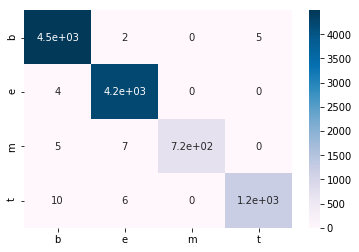

In [18]:
import seaborn as sns

sns.heatmap(train_cm, annot=True, cmap='PuBu')

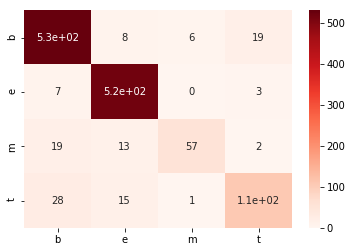

In [19]:
import seaborn as sns

sns.heatmap(test_cm, annot=True, cmap="Reds")

## 56. 適合率，再現率，F1スコアの計測
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．  
カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

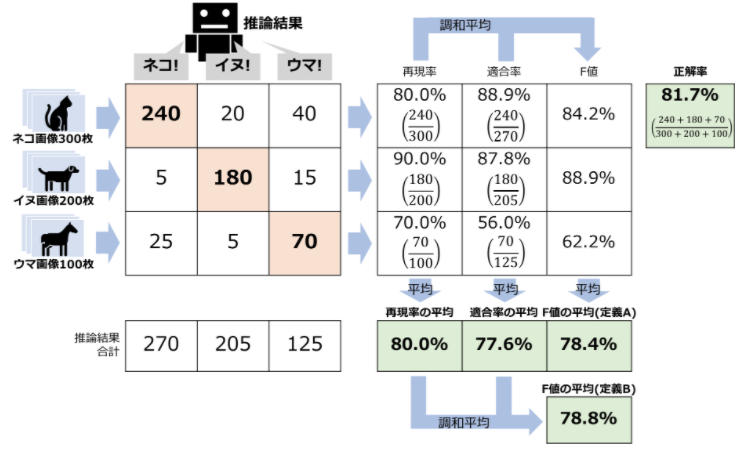

### F1スコアの求め方

$$ F_1 = \frac{2}{\frac{1}{recall}+\frac{1}{precision}} $$

式変形すると...

$$ F_1 = \frac{2\cdot recall \cdot precision}{recall + precision} $$

### Fβスコアの求め方

$$ F_\beta = \frac{1+\beta^2}{\frac{\beta^2}{recall}+\frac{1}{precision}} $$

### マクロ平均

単純に各クラスの適合率，　再現率の平均

### マイクロ平均
精度，　適合率，　再現率，　F1スコアが全て同じになる

In [20]:
# 適合率を計算
def calc_precision(category):

    precision = test_cm.at[category, category] / sum(test_cm.loc[:, category]) * 100
    
    return float(format(precision, ".2f"))

# 再現率を計算
def calc_recall(category):
    
    recall = test_cm.at[category, category] / sum(test_cm.loc[category, :]) * 100
    
    return float(format(recall, ".2f"))

# F1スコアを計算
def calc_f1(category):
    
    precision = calc_precision(category)
    recall = calc_recall(category)
    
    f1 = (2 * precision * recall) / (recall + precision)
    
    return float(format(f1, ".2f"))

# カテゴリ b の適合率
print("カテゴリ： b(business)")
print("適合率 : {} %".format(calc_precision("b")))
print("再現率 : {} %".format(calc_recall("b")))
print("F1スコア : {} %".format(calc_f1("b")))
print("=========================")

# カテゴリ e の適合率
print("カテゴリ： e(entertainment)")
print("適合率 : {} %".format(calc_precision("e")))
print("再現率 : {} %".format(calc_recall("e")))
print("F1スコア : {} %".format(calc_f1("e")))
print("=========================")

# カテゴリ m の適合率
print("カテゴリ： m(health)")
print("適合率 : {} %".format(calc_precision("m")))
print("再現率 : {} %".format(calc_recall("m")))
print("F1スコア : {} %".format(calc_f1("m")))
print("=========================")

# カテゴリ t の適合率
print("カテゴリ： t(science and technology)")
print("適合率 : {} %".format(calc_precision("t")))
print("再現率 : {} %".format(calc_recall("t")))
print("F1スコア : {} %".format(calc_f1("t")))
print("o=o=o=o=o=o=o=o=o=o=o=o=o=o")

# マクロ平均
macro_precision = (calc_precision("b")+calc_precision("e")+calc_precision("m")+calc_precision("t")) / 4
macro_recall = (calc_recall("b")+calc_recall("e")+calc_recall("m")+calc_recall("t")) / 4
macro_f1 = (calc_f1("b")+calc_f1("e")+calc_f1("m")+calc_f1("t")) / 4
print("適合率のマクロ平均 : {} %".format(format(macro_precision, ".2f")))
print("再現率のマクロ平均 : {} %".format(format(macro_recall, ".2f")))
print("F1スコアのマクロ平均 : {} %".format(format(macro_f1, ".2f")))
print("=========================")

# マイクロ平均
print("適合率のマイクロ平均 : {} %".format(format(test_accuracy*100, '.2f')))
print("再現率のマイクロ平均 : {} %".format(format(test_accuracy*100, '.2f')))
print("F1スコアのマイクロ平均 : {} %".format(format(test_accuracy*100, '.2f')))

カテゴリ： b(business)
適合率 : 90.75 %
再現率 : 94.14 %
F1スコア : 92.41 %
カテゴリ： e(entertainment)
適合率 : 93.5 %
再現率 : 98.11 %
F1スコア : 95.75 %
カテゴリ： m(health)
適合率 : 89.06 %
再現率 : 62.64 %
F1スコア : 73.55 %
カテゴリ： t(science and technology)
適合率 : 81.82 %
再現率 : 71.05 %
F1スコア : 76.06 %
o=o=o=o=o=o=o=o=o=o=o=o=o=o
適合率のマクロ平均 : 88.78 %
再現率のマクロ平均 : 81.48 %
F1スコアのマクロ平均 : 84.44 %
適合率のマイクロ平均 : 90.93 %
再現率のマイクロ平均 : 90.93 %
F1スコアのマイクロ平均 : 90.93 %


In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

# sklearn を使って計算する
macro_precision = precision_score(test_df["CATEGORY"], test_pred, average="macro")*100
macro_recall = recall_score(test_df["CATEGORY"], test_pred, average="macro")*100
macro_f1 = f1_score(test_df["CATEGORY"], test_pred, average="macro")*100
print("適合率のマクロ平均 : {} %".format(format(macro_precision, ".2f")))
print("再現率のマクロ平均 : {} %".format(format(macro_recall, ".2f")))
print("F1スコアのマクロ平均 : {} %".format(format(macro_f1, ".2f")))
print("=========================")

micro_precision = precision_score(test_df["CATEGORY"], test_pred, average="micro")*100
micro_recall = recall_score(test_df["CATEGORY"], test_pred, average="micro")*100
micro_f1 = f1_score(test_df["CATEGORY"], test_pred, average="micro")*100
print("適合率のマクロ平均 : {} %".format(format(micro_precision, ".2f")))
print("再現率のマクロ平均 : {} %".format(format(micro_recall, ".2f")))
print("F1スコアのマクロ平均 : {} %".format(format(micro_f1, ".2f")))

適合率のマクロ平均 : 88.78 %
再現率のマクロ平均 : 81.48 %
F1スコアのマクロ平均 : 84.44 %
適合率のマクロ平均 : 90.93 %
再現率のマクロ平均 : 90.93 %
F1スコアのマクロ平均 : 90.93 %


## 57. 特徴量の重みの確認
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

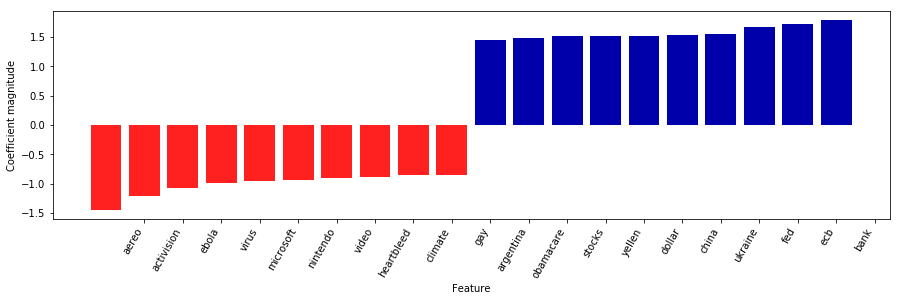

In [22]:
import mglearn

# business(b)
mglearn.tools.visualize_coefficients(model.coef_[0], count_vectorizer.get_feature_names(), n_top_features=10)

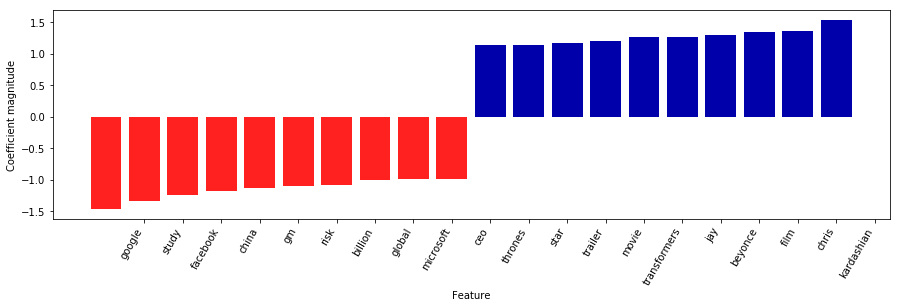

In [23]:
# entertainment(e)


mglearn.tools.visualize_coefficients(model.coef_[1], count_vectorizer.get_feature_names(), n_top_features=10)

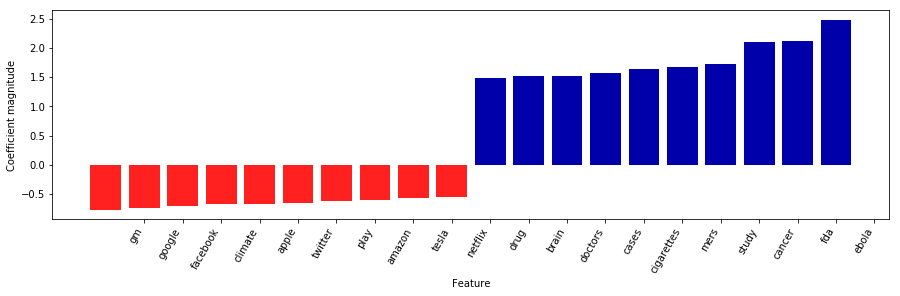

In [24]:
# health(m)

mglearn.tools.visualize_coefficients(model.coef_[2], count_vectorizer.get_feature_names(), n_top_features=10)

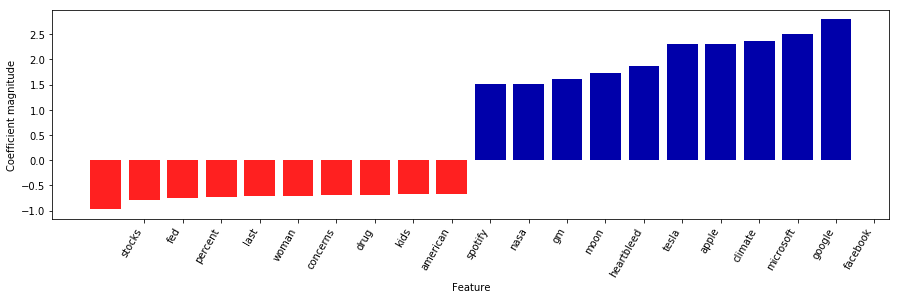

In [25]:
# science and technology(t)

mglearn.tools.visualize_coefficients(model.coef_[3], count_vectorizer.get_feature_names(), n_top_features=10)

## 58. 正則化パラメータの変更
1. ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．
2. 実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [26]:
from tqdm  import tqdm

In [27]:
C = np.logspace(-5, 5, 11, base=10) # 10^-5 ~ 10^5 までの11個
best_val_score = 0

train_result = []
val_result = []
test_result = []

for c in tqdm(C):
    lg_model= LogisticRegression(C=c, max_iter=10000, random_state=2021)
    lg_model.fit(train_feature_df, train_df['CATEGORY'])
    
    train_pred = lg_model.predict(train_feature_df)
    train_accuracy = accuracy_score(train_df['CATEGORY'], train_pred)*100
    train_result.append(round(train_accuracy, 2))
    
    val_pred = lg_model.predict(val_feature_df)
    val_accuracy = accuracy_score(val_df['CATEGORY'], val_pred)*100
    val_result.append(round(val_accuracy, 2))
    
    test_pred = lg_model.predict(test_feature_df)
    test_accuracy = accuracy_score(test_df['CATEGORY'], test_pred)*100
    test_result.append(round(test_accuracy, 2))

100%|██████████| 11/11 [27:22<00:00, 149.29s/it]


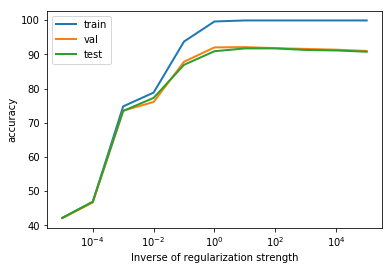

In [28]:
# グラフの作成
plt.plot(C, train_result, linewidth = 2, label = "train")
plt.plot(C, val_result, linewidth = 2, label = "val")
plt.plot(C, test_result, linewidth = 2, label = "test")

# logスケールで軸を作成
plt.xscale('log')

# タイトルの追加
plt.xlabel("Inverse of regularization strength")
plt.ylabel("accuracy")

# 凡例の追加
plt.legend()

## 59. ハイパーパラメータの探索
1. 学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．
2. また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [31]:
# 正則化パラメータ 1~10
C = np.linspace(1, 10, 10)

# クラスの重み
weights = [None,  'balanced']

# 学習アルゴリズム
#solver = ['newton-cg', 'lbfgs', 'sag', 'saga']
solver = ["newton-cg"]
best_score = 0
best_params = {}
for c in tqdm(C):
    for w in weights:
        for s in solver:
            lg_model= LogisticRegression(C=c, class_weight=w, solver=s, max_iter=10000, random_state=2021)
            lg_model.fit(train_feature_df, train_df['CATEGORY'])

            train_pred = lg_model.predict(train_feature_df)
            train_accuracy = accuracy_score(train_df['CATEGORY'], train_pred)*100

            val_pred = lg_model.predict(val_feature_df)
            val_accuracy = accuracy_score(val_df['CATEGORY'], val_pred)*100
            if val_accuracy > best_score:
                best_score = val_accuracy
                best_params["val_score"] = round(val_accuracy, 2)

                test_pred = lg_model.predict(test_feature_df)
                test_accuracy = accuracy_score(test_df['CATEGORY'], test_pred)*100
                best_params["test_score"] = round(test_accuracy, 2)

                best_params["train_score"] = round(train_accuracy, 2)
                best_params["C"] = c
                best_params["class_weight"] = w
                best_params["solver"] = s
print(best_params)

100%|██████████| 10/10 [26:36<00:00, 159.66s/it]

{'val_score': 92.65, 'test_score': 91.9, 'train_score': 99.37, 'C': 1.0, 'class_weight': 'balanced', 'solver': 'newton-cg'}


In [33]:
# 正則化パラメータ 1~10
C = np.linspace(1, 10, 10)

# クラスの重み
weights = [None,  'balanced']

# 学習アルゴリズム
#solver = ['newton-cg', 'lbfgs', 'sag', 'saga']
solver = ["lbfgs"]
best_score = 0
best_params = {}
for c in tqdm(C):
    for w in weights:
        for s in solver:
            lg_model= LogisticRegression(C=c, class_weight=w, solver=s, max_iter=10000, random_state=2021)
            lg_model.fit(train_feature_df, train_df['CATEGORY'])

            train_pred = lg_model.predict(train_feature_df)
            train_accuracy = accuracy_score(train_df['CATEGORY'], train_pred)*100

            val_pred = lg_model.predict(val_feature_df)
            val_accuracy = accuracy_score(val_df['CATEGORY'], val_pred)*100
            if val_accuracy > best_score:
                best_score = val_accuracy
                best_params["val_score"] = round(val_accuracy, 2)

                test_pred = lg_model.predict(test_feature_df)
                test_accuracy = accuracy_score(test_df['CATEGORY'], test_pred)*100
                best_params["test_score"] = round(test_accuracy, 2)

                best_params["train_score"] = round(train_accuracy, 2)
                best_params["C"] = c
                best_params["class_weight"] = w
                best_params["solver"] = s
print(best_params)

100%|██████████| 10/10 [14:31<00:00, 87.12s/it]

{'val_score': 92.65, 'test_score': 91.9, 'train_score': 99.37, 'C': 1.0, 'class_weight': 'balanced', 'solver': 'lbfgs'}


In [37]:
# 正則化パラメータ 1~10
#C = np.linspace(1, 10, 10)
C = [1.0]
# クラスの重み
weights = [None,  'balanced']

# 学習アルゴリズム
#solver = ['newton-cg', 'lbfgs', 'sag', 'saga']
solver = ["saga"] #multi cpuで処理できなかったためCの値は1つのみ実験
best_score = 0
best_params = {}
for c in tqdm(C):
    for w in weights:
        for s in solver:
            lg_model= LogisticRegression(C=c, class_weight=w, solver=s, n_jobs=-1, max_iter=10000, random_state=2021)
            lg_model.fit(train_feature_df, train_df['CATEGORY'])

            train_pred = lg_model.predict(train_feature_df)
            train_accuracy = accuracy_score(train_df['CATEGORY'], train_pred)*100

            val_pred = lg_model.predict(val_feature_df)
            val_accuracy = accuracy_score(val_df['CATEGORY'], val_pred)*100
            if val_accuracy > best_score:
                best_score = val_accuracy
                best_params["val_score"] = round(val_accuracy, 2)

                test_pred = lg_model.predict(test_feature_df)
                test_accuracy = accuracy_score(test_df['CATEGORY'], test_pred)*100
                best_params["test_score"] = round(test_accuracy, 2)

                best_params["train_score"] = round(train_accuracy, 2)
                best_params["C"] = c
                best_params["class_weight"] = w
                best_params["solver"] = s
print(best_params)

100%|██████████| 1/1 [1:25:30<00:00, 5130.79s/it]

{'val_score': 92.5, 'test_score': 91.9, 'train_score': 99.2, 'C': 1.0, 'class_weight': 'balanced', 'solver': 'saga'}


In [38]:
# 正則化パラメータ 1~10
#C = np.linspace(1, 10, 10)
C = [1.0]
# クラスの重み
weights = [None,  'balanced']

# 学習アルゴリズム
#solver = ['newton-cg', 'lbfgs', 'sag', 'saga']
solver = ["sag"] #multi cpuで処理できなかったためCの値は1つのみ実験
best_score = 0
best_params = {}
for c in tqdm(C):
    for w in weights:
        for s in solver:
            lg_model= LogisticRegression(C=c, class_weight=w, solver=s, n_jobs=-1, max_iter=10000, random_state=2021)
            lg_model.fit(train_feature_df, train_df['CATEGORY'])

            train_pred = lg_model.predict(train_feature_df)
            train_accuracy = accuracy_score(train_df['CATEGORY'], train_pred)*100

            val_pred = lg_model.predict(val_feature_df)
            val_accuracy = accuracy_score(val_df['CATEGORY'], val_pred)*100
            if val_accuracy > best_score:
                best_score = val_accuracy
                best_params["val_score"] = round(val_accuracy, 2)

                test_pred = lg_model.predict(test_feature_df)
                test_accuracy = accuracy_score(test_df['CATEGORY'], test_pred)*100
                best_params["test_score"] = round(test_accuracy, 2)

                best_params["train_score"] = round(train_accuracy, 2)
                best_params["C"] = c
                best_params["class_weight"] = w
                best_params["solver"] = s
print(best_params)

100%|██████████| 1/1 [43:44<00:00, 2624.87s/it]

{'val_score': 92.5, 'test_score': 91.9, 'train_score': 99.32, 'C': 1.0, 'class_weight': 'balanced', 'solver': 'sag'}


### パラメータチューニングの結果

#### CountVectorizer
学習データの正解率：99.37  
評価データの正解率：92.65  
テストデータの正解率 : 91.90
- ngram_range=(1, 3)
- min_df=2
- C : 1.0
- class_weight : balanced  
- solver : 'newton-cg', 'lbfgs'   

テストデータの正解率はどのアルゴリズムでも変わらない